In [1]:
import os
from keras.utils import get_file
import gensim
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(10, 10)

In [2]:
import tensorflow as tf

# Set up the GPU to avoid the runtime error: Could not create cuDNN handle...
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
# We'll start the program by the GoogleNews in the local file. 

model_path = "/home/mic/datasets/GoogleNews-vectors-negative300.bin"

# Local path for the model 
model = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [4]:
# most_similar(): compute the cosine distance  
model.most_similar(positive=['espresso'])

[('cappuccino', 0.6888187527656555),
 ('mocha', 0.6686208248138428),
 ('coffee', 0.6616826057434082),
 ('latte', 0.653675377368927),
 ('caramel_macchiato', 0.6491267681121826),
 ('ristretto', 0.6485545635223389),
 ('espressos', 0.6438629031181335),
 ('macchiato', 0.6428249478340149),
 ('chai_latte', 0.6308028697967529),
 ('espresso_cappuccino', 0.6280542612075806)]

In [5]:
def A_is_to_B_as_C_is_to(a, b, c, topn=1):
    # map() returns iterables, if no list disgnated, need to convert to the list format 
    # such as [x] that include x in the sqaure bracker [] in the else clause. 
    a, b, c = map(lambda x:x if type(x) == list else [x], (a, b, c))
    # topn: three words most similar 
    res = model.most_similar(positive=b + c, negative=a, topn=topn)
    if len(res):
        if topn == 1:
            return res[0][0]
        return [x[0] for x in res]
    return None

In [6]:
A_is_to_B_as_C_is_to('man', 'woman', 'king')

'queen'

In [7]:
# We can use this equation to acurately predict the capitals of countries by looking at what 
# has the same relationship as Berlin has to Germany for selected countries:

for country in 'Italy', 'France', 'India', 'China':
    print('%s is the capital of %s' % 
          (A_is_to_B_as_C_is_to('Germany', 'Berlin', country), country))
          # (A_is_to_B_as_C_is_to('Germany', 'Berlin', country), country))

Rome is the capital of Italy
Paris is the capital of France
Delhi is the capital of India
Beijing is the capital of China


In [8]:
# Or we can do the same for important products for given companies. Here we seed the products 
# equation with two products, the iPhone for Apple and Starbucks_coffee for Starbucks. Note 
# that numbers are replaced by # in the embedding model:

for company in 'Google', 'IBM', 'Boeing', 'Microsoft', 'Samsung':
    products = A_is_to_B_as_C_is_to(
        ['Starbucks', 'Apple'], 
        ['Starbucks_coffee', 'iPhone'], 
        company, topn=3)
    print('%s -> %s' % 
          (company, ', '.join(products)))

Google -> personalized_homepage, app, Gmail
IBM -> DB2, WebSphere_Portal, Tamino_XML_Server
Boeing -> Dreamliner, airframe, aircraft
Microsoft -> Windows_Mobile, SyncMate, Windows
Samsung -> MM_A###, handset, Samsung_SCH_B###


In [9]:
# Or we can do the same for important products for given companies. Here we seed the products 
# equation with two products, the iPhone for Apple and Starbucks_coffee for Starbucks. Note 
# that numbers are replaced by # in the embedding model:

for company in 'Google', 'IBM', 'Boeing', 'Microsoft', 'Samsung':
    products = A_is_to_B_as_C_is_to(
        ['Starbucks', 'Apple'], 
        ['Starbucks_coffee', 'iPhone'], 
        company, topn=3)
    print('%s -> %s' % 
          (company, ', '.join(products)))

Google -> personalized_homepage, app, Gmail
IBM -> DB2, WebSphere_Portal, Tamino_XML_Server
Boeing -> Dreamliner, airframe, aircraft
Microsoft -> Windows_Mobile, SyncMate, Windows
Samsung -> MM_A###, handset, Samsung_SCH_B###


In [10]:
# Let's do some clustering by picking three categories of items, drinks, countries and sports:

beverages = ['espresso', 'beer', 'vodka', 'wine', 'cola', 'tea']
countries = ['Italy', 'Germany', 'Russia', 'France', 'USA', 'India']
sports = ['soccer', 'handball', 'hockey', 'cycling', 'basketball', 'cricket']

items = beverages + countries + sports
len(items)

18

In [11]:
# And looking up their vectors:

item_vectors = [(item, model[item]) 
                    for item in items
                    if item in model]
len(item_vectors)

18

In [12]:
# Now use TSNE for clustering:

from sklearn.manifold import TSNE

vectors = np.asarray([x[1] for x in item_vectors])
lengths = np.linalg.norm(vectors, axis=1)
norm_vectors = (vectors.T / lengths).T

tsne = TSNE(n_components=2, perplexity=10, verbose=2).fit_transform(norm_vectors)

[t-SNE] Computing 17 nearest neighbors...
[t-SNE] Indexed 18 samples in 0.000s...
[t-SNE] Computed neighbors for 18 samples in 0.078s...
[t-SNE] Computed conditional probabilities for sample 18 / 18
[t-SNE] Mean sigma: 0.581543
[t-SNE] Computed conditional probabilities in 0.033s
[t-SNE] Iteration 50: error = 47.3403854, gradient norm = 0.2760773 (50 iterations in 0.023s)
[t-SNE] Iteration 100: error = 64.2329636, gradient norm = 0.6158621 (50 iterations in 0.009s)
[t-SNE] Iteration 150: error = 58.5155792, gradient norm = 0.1716881 (50 iterations in 0.009s)
[t-SNE] Iteration 200: error = 55.1617661, gradient norm = 0.0663884 (50 iterations in 0.009s)
[t-SNE] Iteration 250: error = 49.7304192, gradient norm = 0.0579752 (50 iterations in 0.009s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 49.730419
[t-SNE] Iteration 300: error = 0.8093246, gradient norm = 0.0009591 (50 iterations in 0.009s)
[t-SNE] Iteration 350: error = 0.5392826, gradient norm = 0.0004506 (50 i

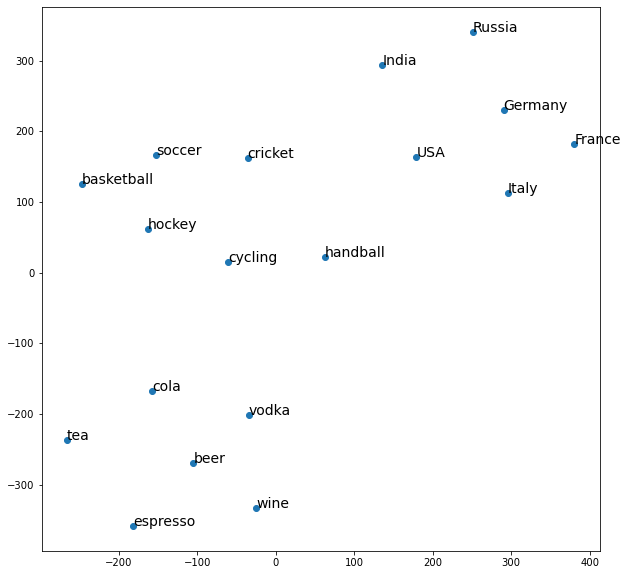

In [13]:
# And matplotlib to show the results. As you can see the countries, sports and drinks all form 
# their own little clusters, with arguably cricket and India attracting each other and maybe 
# less clear, wine and France and Italy and espresso.

x=tsne[:,0]
y=tsne[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)

for item, x1, y1 in zip(item_vectors, x, y):
    ax.annotate(item[0], (x1, y1), size=14)

plt.show()

In [14]:
# Release the GPU memory

from numba import cuda

cuda.select_device(0)
cuda.close()